# Generative Adversarial Network (GAN)

**Authors: Thomas Pierrot**

*A short tutorial to explain and experiment how GANs work through easy examples. We will be using Pytorch during this notebook.*

##### First let's import some prerequisites, while you'll read the introduction.

In [3]:
%matplotlib inline

import itertools
import math
import time
import os

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable

## Introduction

### Motivation

>**Yann LeCun**, *Director of AI Research at Facebook and Professor at NYU* :
>
>
>>"There are many interesting recent development in deep learning, probably too many for me to describre them all here. But there are a few ideas that caught my attention enough for me to get personally involved in research projects.
>>
>>The most important one, in my opinion, is adversarial training (also called GAN for Generative Adversarial Networks). This is an idea that was originally proposed by Ian Goodfellow whe he was a student with Yoshua Bengio at the University of Montreal (he since moved to Google Brain and recently to OpenAI).
>>
>>This, and the variations that are now being proposed is the most interesting idea in the last  years in ML, in my opinion."

### What is the initial goal of GANs ? 

<div class="alert alert-success" style="margin-top: 1em">
<b>Generative Adversarial Networks (GAN)</b> are a new framework for generating models. <b>The idea is to generate data that looks real, but that does not already exist.</b><br/>
For example, generating images of hand-written numbers that seem man made by training such a network on the MNIST database. 
</div> 

In this framework, two assumptions have to be made:
<ul>
<li> All the data from the training dataset is assumed to follow the same probability distribution noted $p_{data}$. In other words, if the MNIST database is considered, all the 28x28 matrices which represent hand-written numbers are assumed to follow the same probability distribution.</li>
    

<li> The database is assumed large enough that the probability distribution obtained represent well and only those data. In other words, if new sample can be generated from this distribution, they should look like the other elements of the database. In the case of the MNIST database, if new 28x28 matrices may be generated from the distribution $p_{data}$, then they should still represent hand-written numbers.</li>
</ul>

### Load training data

As suggested above, we will practise on Mnist database. Basically, we will learn to our computer how to write figures.

In [4]:
# set batch_size
batch_size = 100

# the data, shuffled and split between train and test sets
# we normalize data to have values between -1 and 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) ])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
train_iterator = iter(train_loader)

Let's have a look at some examples of the training data.

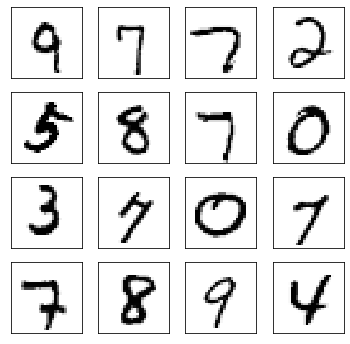

In [5]:
num_test_samples = 16 # number of digits to plot

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# load a batch of training data
images, labels = next(train_iterator)

# show a subpart of it
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)

### How to train such a network ?

##### The Generator

<div class="alert alert-block alert-info">
A first network - called <b>Generator</b>- is built and is meant to transform vectors following a random probability distribution $p_z$ - called noise probability distribution - in vectors following natural data distribution $p_{data}$.<br/>
<br/>
<b>In other words,</b> to create fake data from scratch that looks like the real data from the DB.

</div>

To keep the MNIST example, a generator could take as input vectors of real numbers following a gaussian distribution and should output a 28x28 matrix whose each value follows the data probability distribution followed by MNIST images. Hence, that network role would be to transform a gaussian distribution into a probability distribution followed by natural - and in this case man made - samples.

##### The Discriminator

To train the generator, Ian Goodfellow suggested to build a second network called the **Discriminator**. 

<div class="alert alert-block alert-info">
The <b>Discriminator</b>'s goal is to make the difference between samples following the real data probability distribution and samples generated by the generator. It takes as an input either a real sample or a sample output from the generator - called fake sample - and is trained to return the likelyhood of the image being a real one. <br/>
<br/>
<b>In other words,</b> the discriminator is expected to return 1 when it is fed with an image from the training dataset and to return 0 when it is fed with an image generated by the generator.
</div>

Then the generator is trained to fool the discriminator : ie to make it return 1 for fake samples too. Therefore, both network play together a 2 players minimax game. At the equilibrium, the discriminator should always return 0.5 : it cannot make the difference between real and fake samples anymore, hence the fake samples follow the same probability distribution than real ones. The generator is trained that way and produces real-like results.

### A more mathematical point of view
To get a better understanding, let us call G the generator, D the discriminator, $z$ a variable following the noise probability distribution $p_z$ and $x$ a variable following the data probability distribution $p_{data}$. Let us call as well $p_g$ the probability distribution followed by G’s outputs : $G(z)$. Then the generator goal is to fool the discriminator returning real like samples which means equalizing $p_g$ and $p_{data}$ . Hence, the discriminator is trained to return $1$ for real data : $D(x) = 1$ and $0$ for fake data $D(G(z)) = 0$ while the generator is trained to make the discriminator returning $1$ as well for fake data. Hence, D and G play the two-player minimax game with value function $V(G, D)$ suggested by Ian Goodfellow:

$$\min_{G} \max_{D} V(D,G)  = \mathbb{E}_{x\sim p_{data}}[log D(x)] + \mathbb{E}_{z\sim p_{z}}[log(1 - D(G(z)))]$$

The implementation of this game results in the following algorithm, described in the original GAN paper:

<img src="./Images/gan_algo.png" style="max-width:100%; width: 70%">

# Time to implement our first GAN!


### Build the neural networks

We now build both the networks. In this notebook, as in the original paper, both will be simple fully connected network.

<img src="./Images/schema_gan_mnist.png" style="max-width:100%; width: 70%">


**It's your turn!**

We give you the **Discriminator** code, you can take inspiration from it for the **Generator**. 

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

Once the class are written, we instantiate the networks.

In [8]:
discriminator = Discriminator()
generator = Generator()

We also initialize the optimizers.

In [9]:
criterion = nn.BCELoss() #BCE standing for Binary Cross Entropy
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

And write both the discriminator and generator train functions.

In [10]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [11]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

# Train the model!
The moment of truth : we will train GAN networks on our database. 

<div class="alert alert-danger">
<b>Warning :</b>
This operation will take some time, depending on the value of the batch and the number of epochs you defined, and on your computer performances.<br/>

In [12]:
# Prepare folder to store results
if not os.path.exists('results'):
    os.makedirs('results')
    
# Prepare folder to store models
if not os.path.exists('models'):
    os.makedirs('models')

In [13]:
# Draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))

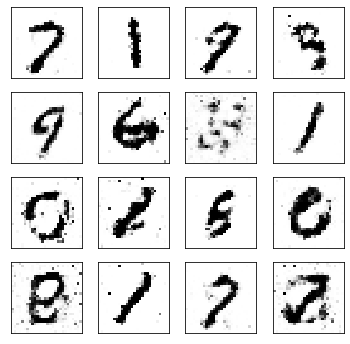

Epoch [30/30], Step[600/600], d_loss: 1.1833, g_loss: 1.1833, D(x): 0.59, D(G(z)): 0.36, time 75.11 min


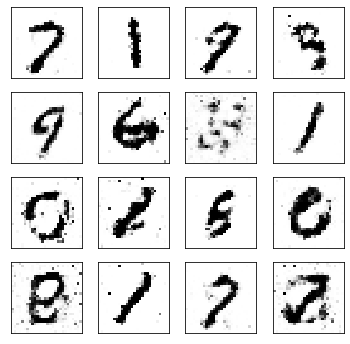

In [15]:
# Create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Set number of epochs and initialize figure counter
num_epochs = 30
num_batches = len(train_loader)

# Set counter
num_fig = 0

# Start timer
t0 = time.time()

# Start training
for epoch in range(num_epochs):  
    for n, (images, _) in enumerate(train_loader):
        
        # Convert data to suitable format
        images = Variable(images)
        real_labels = Variable(torch.ones(images.size(0), 1))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0), 1))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        # Every half epoch generates pictures with to generator to monitor training
        if (n+1) % int(num_batches/2) == 0:
            # generate pictures
            test_images = generator(test_noise)
            
            # plot them
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            # save the picture
            plt.savefig('results/mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            # print log
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f, time %.2f min' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.detach().numpy(), g_loss.detach().numpy(),
                    real_score.detach().numpy().mean(), fake_score.detach().numpy().mean(), (time.time()-t0)/60))
            
#         # at the end of each epoch, save the models
#         torch.save(generator.state_dict(), os.path.join('models', 'generator.pkl'))
#         torch.save(discriminator.state_dict(), os.path.join('models', 'discriminator.pkl'))

### And an hand-made comics to end this notebook, enjoy :)
Thank you baptiste !

<img src="./Images/Melusine1.jpg" style="width: 700px;">

<img src="./Images/Melusine2.jpg" style="width: 700px;">